# Author: Aditya Yadav

# Notebook 4: Random Forest for Smoking Prediction

In this notebook, we'll implement and evaluate the Random Forest algorithm for predicting smoking status based on health indicators. We'll use the cleaned datasets prepared in Notebook 1.

## Understanding Random Forest

Random Forest is an ensemble learning method that builds upon decision trees to create a more powerful and robust classifier. Here's how it works:

1. It creates multiple decision trees (a "forest") by training each tree on a random subset of the data (bootstrap sampling)
2. When splitting nodes, it considers only a random subset of features, introducing further diversity among trees
3. For classification, the final prediction is made by majority voting across all trees

### Advantages of Random Forest:
- Reduces overfitting compared to individual decision trees
- Handles high-dimensional data well without feature scaling
- Provides feature importance measures
- Robust to outliers and non-linear data
- Generally performs very well "out of the box" with less tuning

### Limitations of Random Forest:
- Less interpretable than single decision trees
- Can be computationally intensive for large datasets
- May overfit on some noisy datasets
- Can be biased towards features with more levels in categorical variables

Let's implement Random Forest for our smoking prediction task and optimize its key parameters such as the number of trees (n_estimators) and the maximum depth of trees.

## 1. Import Libraries and Load Data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# For Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Set random seed for reproducibility
RANDOM_STATE = 42

# Set up visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load the full and reduced datasets
df_full = pd.read_csv('smoking_cleaned_full.csv')
df_reduced = pd.read_csv('smoking_cleaned_reduced.csv')

# Display basic information about the datasets
print(f"Full dataset shape: {df_full.shape}")
print(f"Reduced dataset shape: {df_reduced.shape}")

# Verify that both datasets have the target variable
print(f"\nTarget variable 'smoking' distribution in full dataset:\n{df_full['smoking'].value_counts()}")
print(f"\nTarget variable 'smoking' distribution in reduced dataset:\n{df_reduced['smoking'].value_counts()}")

Full dataset shape: (44084, 30)
Reduced dataset shape: (44084, 16)

Target variable 'smoking' distribution in full dataset:
smoking
0    27972
1    16112
Name: count, dtype: int64

Target variable 'smoking' distribution in reduced dataset:
smoking
0    27972
1    16112
Name: count, dtype: int64


## 2. Data Preparation

Like Decision Trees, Random Forest does not require feature scaling since it's based on decisions about thresholds rather than distances. This is one of the advantages of tree-based ensemble methods.

In [3]:
# Separate features and target for both datasets
X_full = df_full.drop('smoking', axis=1)
y_full = df_full['smoking']

X_reduced = df_reduced.drop('smoking', axis=1)
y_reduced = df_reduced['smoking']

# Split the data into training and testing sets
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_full
)

X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=RANDOM_STATE, stratify=y_reduced
)

print("Data preparation completed successfully.")
print(f"Training set size: {X_full_train.shape[0]} samples")
print(f"Testing set size: {X_full_test.shape[0]} samples")
print(f"Full feature set: {X_full.shape[1]} features")
print(f"Reduced feature set: {X_reduced.shape[1]} features")

Data preparation completed successfully.
Training set size: 35267 samples
Testing set size: 8817 samples
Full feature set: 29 features
Reduced feature set: 15 features


## 3. Optimize Random Forest Parameters

Random Forest has several important hyperparameters that can affect performance:

1. **n_estimators**: The number of trees in the forest. More trees generally means better performance but slower training and prediction.
2. **max_depth**: The maximum depth of each tree. Controls complexity and potential for overfitting.
3. **min_samples_split**: The minimum number of samples required to split an internal node.
4. **min_samples_leaf**: The minimum number of samples required to be at a leaf node.
5. **max_features**: The number of features to consider when looking for the best split.

Let's optimize the two most impactful parameters: n_estimators and max_depth.

In [4]:
# First, let's find optimal n_estimators (number of trees)
n_estimators_range = [10, 50, 100, 150, 200]
n_estimators_scores = []

print("Finding optimal number of trees (n_estimators)...")
for n_estimators in n_estimators_range:
    start_time = time.time()
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=RANDOM_STATE, n_jobs=-1) # Use all CPU cores
    # Use 5-fold cross-validation with F1 score
    scores = cross_val_score(rf, X_reduced_train, y_reduced_train, cv=5, scoring='f1')
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    mean_score = scores.mean()
    n_estimators_scores.append({
        'n_estimators': n_estimators,
        'f1_score': mean_score,
        'training_time': elapsed_time
    })
    print(f"n_estimators={n_estimators}, F1 Score: {mean_score:.4f}, Training Time: {elapsed_time:.2f} seconds")

# Convert to DataFrame for visualization
n_estimators_df = pd.DataFrame(n_estimators_scores)

# Find the best n_estimators
best_n_estimators = n_estimators_df.loc[n_estimators_df['f1_score'].idxmax(), 'n_estimators']
print(f"\nBest n_estimators: {best_n_estimators}")

Finding optimal number of trees (n_estimators)...
n_estimators=10, F1 Score: 0.5956, Training Time: 0.50 seconds
n_estimators=50, F1 Score: 0.6540, Training Time: 1.53 seconds
n_estimators=100, F1 Score: 0.6637, Training Time: 2.89 seconds
n_estimators=150, F1 Score: 0.6674, Training Time: 4.06 seconds
n_estimators=200, F1 Score: 0.6698, Training Time: 5.36 seconds

Best n_estimators: 200


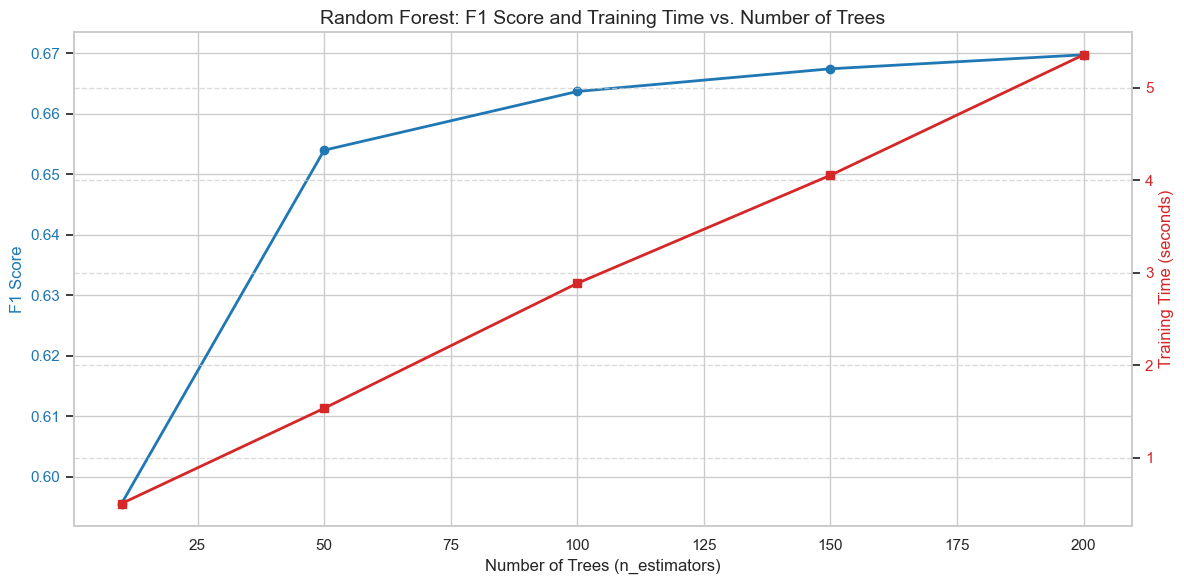

In [5]:
# Visualize n_estimators vs performance
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot F1 Score
color = 'tab:blue'
ax1.set_xlabel('Number of Trees (n_estimators)', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12, color=color)
ax1.plot(n_estimators_df['n_estimators'], n_estimators_df['f1_score'], marker='o', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for training time
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Training Time (seconds)', fontsize=12, color=color)
ax2.plot(n_estimators_df['n_estimators'], n_estimators_df['training_time'], marker='s', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Random Forest: F1 Score and Training Time vs. Number of Trees', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
# Now, let's find optimal max_depth using the best n_estimators
max_depths = [5, 10, 15, 20, 25, 30, None]  # None means unlimited depth
max_depth_scores = []

print(f"Finding optimal max_depth with n_estimators={best_n_estimators}...")
for max_depth in max_depths:
    rf = RandomForestClassifier(
        n_estimators=best_n_estimators, 
        max_depth=max_depth, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    # Use 5-fold cross-validation with F1 score
    scores = cross_val_score(rf, X_reduced_train, y_reduced_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    max_depth_scores.append({
        'max_depth': max_depth if max_depth is not None else 'None',
        'f1_score': mean_score
    })
    print(f"max_depth={max_depth}, F1 Score: {mean_score:.4f}")

# Convert to DataFrame for visualization
max_depth_df = pd.DataFrame(max_depth_scores)

# Find the best max_depth
best_max_depth = max_depth_df.loc[max_depth_df['f1_score'].idxmax(), 'max_depth']
# Convert 'None' string back to None
if best_max_depth == 'None':
    best_max_depth = None
print(f"\nBest max_depth: {best_max_depth}")

Finding optimal max_depth with n_estimators=200...
max_depth=5, F1 Score: 0.6668
max_depth=10, F1 Score: 0.6779
max_depth=15, F1 Score: 0.6764
max_depth=20, F1 Score: 0.6713
max_depth=25, F1 Score: 0.6700
max_depth=30, F1 Score: 0.6671
max_depth=None, F1 Score: 0.6698

Best max_depth: 10


## 4. Training Random Forest Models with Optimal Parameters

Now that we've identified the optimal parameters, let's train our final models for both the full and reduced feature sets:

In [8]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, y_prob=None):
    """Calculate and return performance metrics for a classification model."""
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # ROC AUC (if probability predictions are available)
    roc_auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Train Random Forest with optimal parameters for full feature set
print("Training Random Forest model with full feature set...")
rf_full = RandomForestClassifier(
    n_estimators=best_n_estimators, 
    max_depth=best_max_depth, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_full.fit(X_full_train, y_full_train)

# Train Random Forest with optimal parameters for reduced feature set
print("Training Random Forest model with reduced feature set...")
rf_reduced = RandomForestClassifier(
    n_estimators=best_n_estimators, 
    max_depth=best_max_depth, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_reduced.fit(X_reduced_train, y_reduced_train)

# Make predictions
y_full_pred = rf_full.predict(X_full_test)
y_reduced_pred = rf_reduced.predict(X_reduced_test)

# Get probability predictions
y_full_prob = rf_full.predict_proba(X_full_test)[:, 1]
y_reduced_prob = rf_reduced.predict_proba(X_reduced_test)[:, 1]

# Evaluate performance
full_metrics = evaluate_model(y_full_test, y_full_pred, y_full_prob)
reduced_metrics = evaluate_model(y_reduced_test, y_reduced_pred, y_reduced_prob)

# Display results
print("\nRandom Forest Model with Full Feature Set:")
print(f"Accuracy: {full_metrics['accuracy']:.4f}")
print(f"Precision: {full_metrics['precision']:.4f}")
print(f"Recall: {full_metrics['recall']:.4f}")
print(f"F1 Score: {full_metrics['f1_score']:.4f}")
print(f"ROC AUC: {full_metrics['roc_auc']:.4f}")

print("\nRandom Forest Model with Reduced Feature Set:")
print(f"Accuracy: {reduced_metrics['accuracy']:.4f}")
print(f"Precision: {reduced_metrics['precision']:.4f}")
print(f"Recall: {reduced_metrics['recall']:.4f}")
print(f"F1 Score: {reduced_metrics['f1_score']:.4f}")
print(f"ROC AUC: {reduced_metrics['roc_auc']:.4f}")

Training Random Forest model with full feature set...
Training Random Forest model with reduced feature set...

Random Forest Model with Full Feature Set:
Accuracy: 0.7538
Precision: 0.6446
Recall: 0.7269
F1 Score: 0.6833
ROC AUC: 0.8385

Random Forest Model with Reduced Feature Set:
Accuracy: 0.7489
Precision: 0.6393
Recall: 0.7179
F1 Score: 0.6763
ROC AUC: 0.8345


## 5. Understanding the Evaluation Metrics

Let's review what each metric means in the context of our smoking prediction problem:

1. **Accuracy**: The proportion of correct predictions (both smokers and non-smokers correctly identified) out of all predictions. While intuitive, accuracy can be misleading in imbalanced datasets like ours (63% non-smokers vs. 37% smokers).

2. **Precision**: The proportion of true positive predictions (correctly identified smokers) among all positive predictions. In our context: "When the model predicts someone is a smoker, how often is it right?" High precision means fewer false positives (non-smokers incorrectly classified as smokers).

3. **Recall (Sensitivity)**: The proportion of true positive predictions (correctly identified smokers) among all actual smokers. In our context: "Of all actual smokers, how many did the model correctly identify?" High recall means fewer false negatives (smokers incorrectly classified as non-smokers).

4. **F1 Score**: The harmonic mean of precision and recall, providing a single metric that balances both concerns. This is particularly useful in our case with moderate class imbalance, as it gives equal importance to both precision and recall.

5. **ROC AUC**: Area Under the Receiver Operating Characteristic curve, which measures the model's ability to distinguish between smokers and non-smokers across all possible classification thresholds. Values range from 0.5 (no discriminative power, equivalent to random guessing) to 1.0 (perfect discrimination).

The choice of which metric to prioritize depends on the specific application:
- For applications where false positives are costly (e.g., unnecessary medical interventions), precision should be prioritized.
- For public health screening where missing smokers is more concerning, recall would be more important.
- In balanced scenarios, F1 score and ROC AUC provide good overall assessments of model performance.

## 6. Feature Importance Analysis

One of the benefits of Random Forest is that it provides a measure of feature importance. Let's examine which features contribute most to our prediction:

/var/folders/2n/kd93964174v5lrpxdb4088m40000gp/T/ipykernel_68056/1184051474.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2n/kd93964174v5lrpxdb4088m40000gp/T/ipykernel_68056/1184051474.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


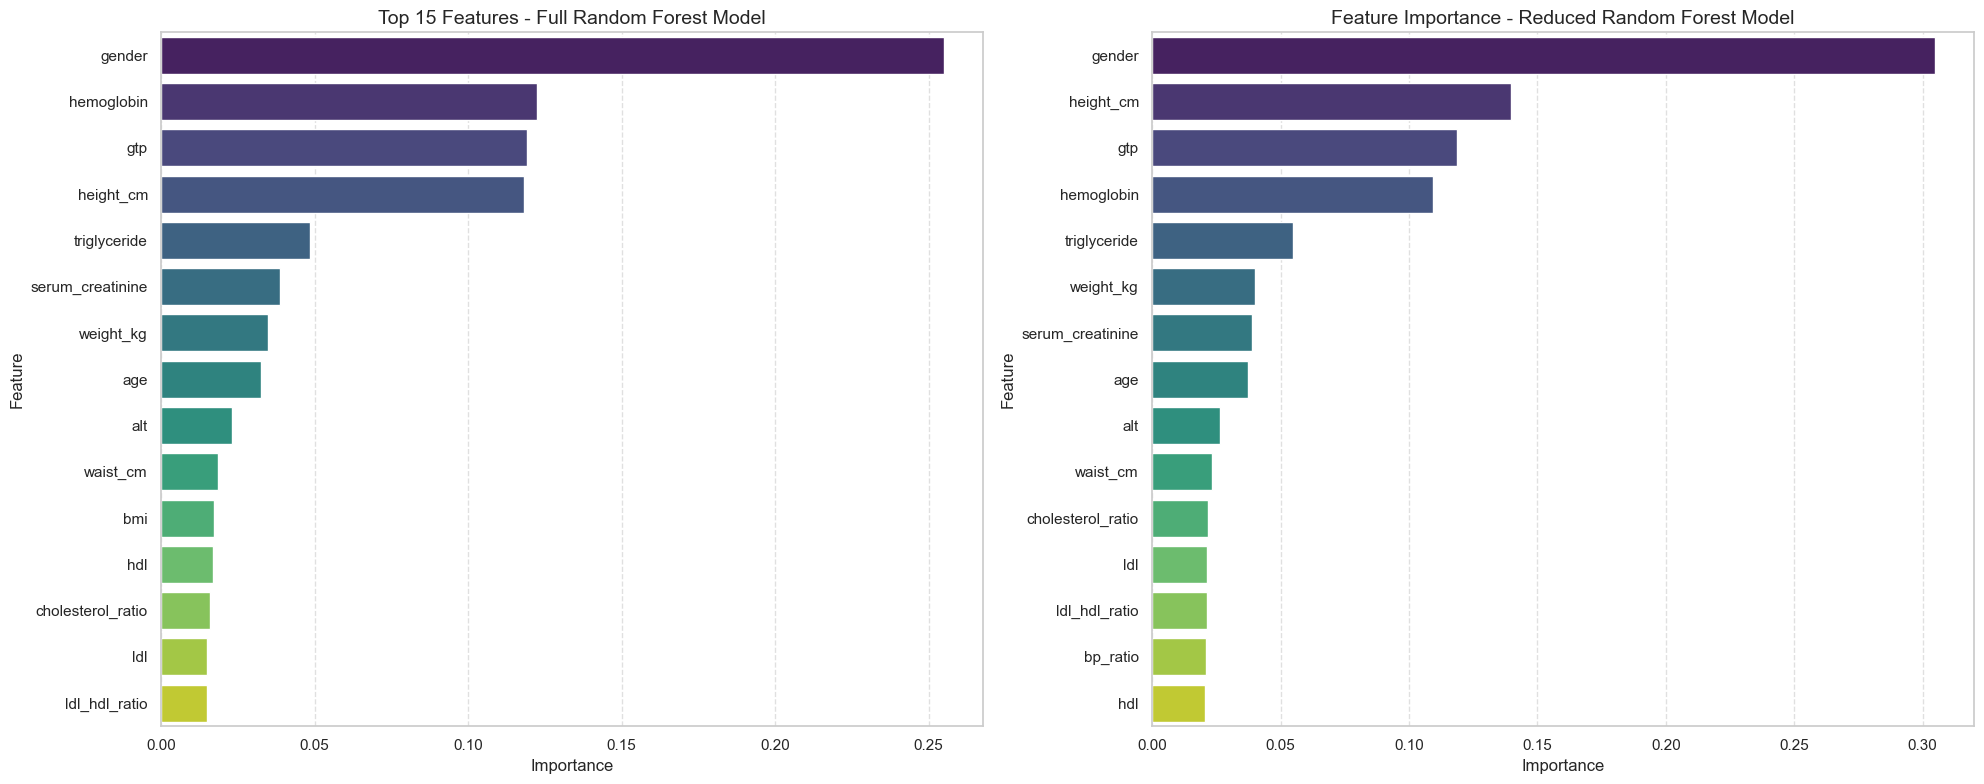

Top 5 Important Features (Full Model):
         Feature  Importance
0         gender    0.254936
16    hemoglobin    0.122450
21           gtp    0.119006
2      height_cm    0.118151
13  triglyceride    0.048386

Top 5 Important Features (Reduced Model):
        Feature  Importance
0        gender    0.304744
3     height_cm    0.139819
1           gtp    0.118712
2    hemoglobin    0.109501
4  triglyceride    0.054854


In [9]:
# Analyze feature importance in the full model
feature_importance_full = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': rf_full.feature_importances_
}).sort_values('Importance', ascending=False)

# Analyze feature importance in the reduced model
feature_importance_reduced = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': rf_reduced.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importances for both models
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Full feature set - show top 15
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_full.head(15), 
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Top 15 Features - Full Random Forest Model', fontsize=14)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# Reduced feature set
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_reduced, 
    ax=axes[1],
    palette='viridis'
)
axes[1].set_title('Feature Importance - Reduced Random Forest Model', fontsize=14)
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_ylabel('Feature', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Print top 5 important features for both models
print("Top 5 Important Features (Full Model):")
print(feature_importance_full.head(5))
print("\nTop 5 Important Features (Reduced Model):")
print(feature_importance_reduced.head(5))

## 7. Visualizing Model Performance

Confusion Matrix for Full Feature Set:


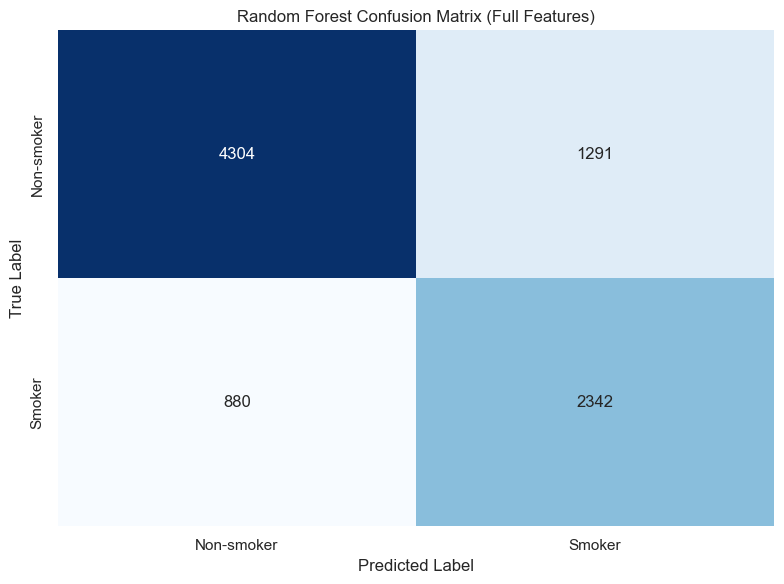

Specificity (True Negative Rate): 0.7693
Negative Predictive Value: 0.8302

Confusion Matrix for Reduced Feature Set:


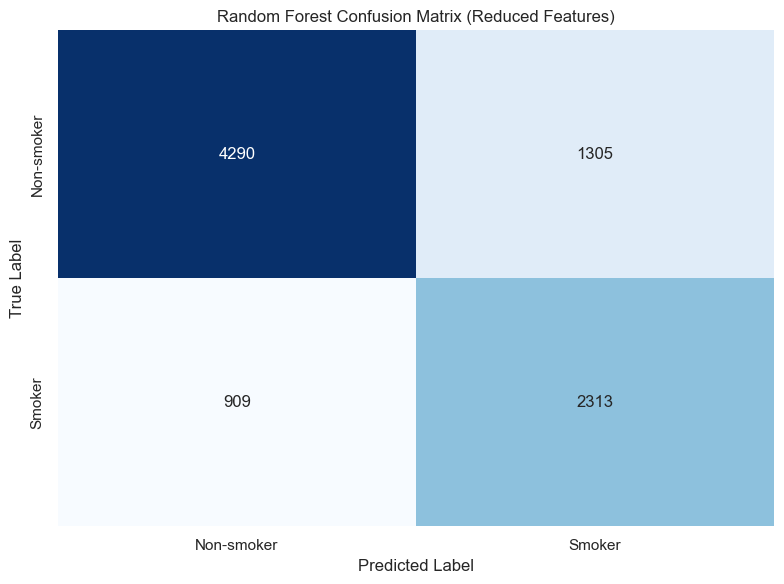

Specificity (True Negative Rate): 0.7668
Negative Predictive Value: 0.8252


In [10]:
# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Non-smoker', 'Smoker'],
               yticklabels=['Non-smoker', 'Smoker'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display derived metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # True negative rate
    npv = tn / (tn + fn)  # Negative predictive value
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")

# Function to plot ROC curves
def plot_roc_curve(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Display confusion matrices
print("Confusion Matrix for Full Feature Set:")
plot_confusion_matrix(y_full_test, y_full_pred, 'Random Forest Confusion Matrix (Full Features)')

print("\nConfusion Matrix for Reduced Feature Set:")
plot_confusion_matrix(y_reduced_test, y_reduced_pred, 'Random Forest Confusion Matrix (Reduced Features)')

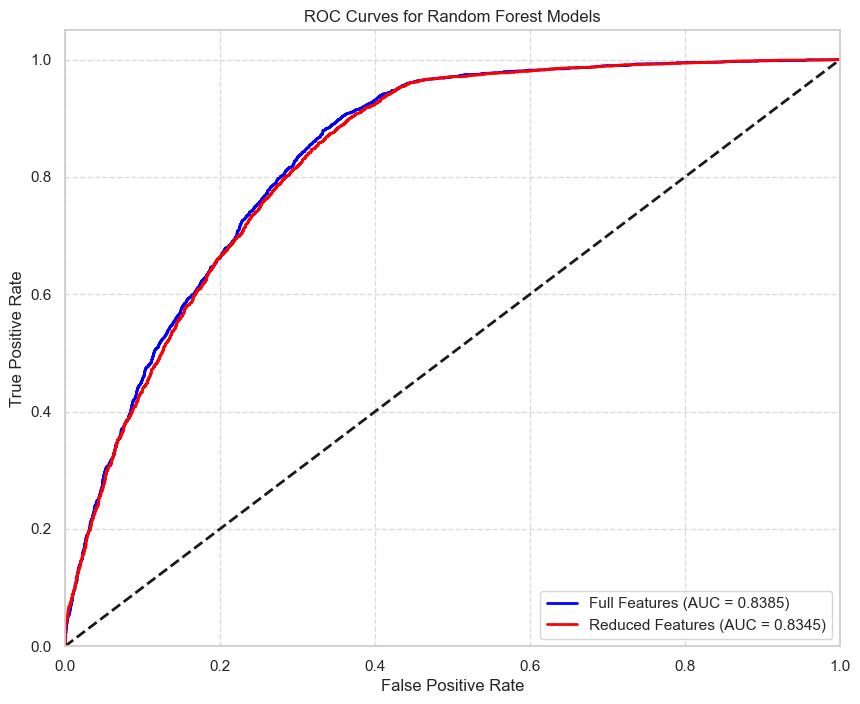

In [11]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for the full feature model
fpr_full, tpr_full, roc_auc_full = plot_roc_curve(y_full_test, y_full_prob, 'Full')
plt.plot(fpr_full, tpr_full, label=f'Full Features (AUC = {roc_auc_full:.4f})', lw=2, color='blue')

# Plot ROC curve for the reduced feature model
fpr_reduced, tpr_reduced, roc_auc_reduced = plot_roc_curve(y_reduced_test, y_reduced_prob, 'Reduced')
plt.plot(fpr_reduced, tpr_reduced, label=f'Reduced Features (AUC = {roc_auc_reduced:.4f})', lw=2, color='red')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest Models')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 8. Comparison of Feature Sets

Let's directly compare the performance of our full and reduced feature sets to see how much predictive power we retain with fewer features:

In [12]:
# Create a comparison DataFrame
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Full Features': [
        full_metrics['accuracy'],
        full_metrics['precision'],
        full_metrics['recall'],
        full_metrics['f1_score'],
        full_metrics['roc_auc']
    ],
    'Reduced Features': [
        reduced_metrics['accuracy'],
        reduced_metrics['precision'],
        reduced_metrics['recall'],
        reduced_metrics['f1_score'],
        reduced_metrics['roc_auc']
    ]
})

# Calculate differences and percentage changes
metrics_comparison['Absolute Difference'] = metrics_comparison['Full Features'] - metrics_comparison['Reduced Features']
metrics_comparison['Percentage Change (%)'] = (metrics_comparison['Absolute Difference'] / metrics_comparison['Full Features']) * 100

# Display the comparison
print("Comparison of Random Forest Performance: Full vs. Reduced Feature Sets")
metrics_comparison.set_index('Metric')

Comparison of Random Forest Performance: Full vs. Reduced Feature Sets


,Full Features,Reduced Features,Absolute Difference,Percentage Change (%)
Metric,,,,
Accuracy,0.753771,0.748894,0.004877,0.647006
Precision,0.644646,0.639303,0.005343,0.828798
Recall,0.726878,0.717877,0.009001,1.238258
F1 Score,0.683297,0.676316,0.006981,1.021675
ROC AUC,0.838461,0.834517,0.003944,0.470374


<Figure size 1200x800 with 0 Axes>

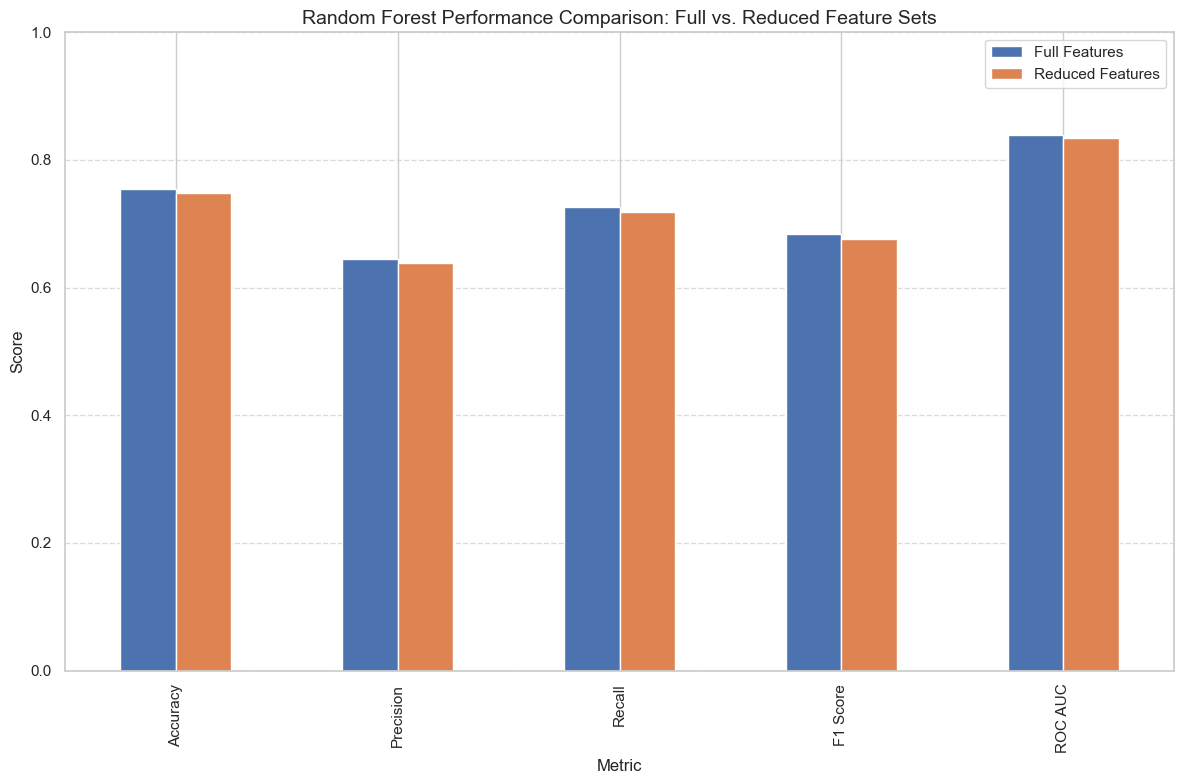

In [13]:
# Visualize the comparison
plt.figure(figsize=(12, 8))
metrics_comparison.set_index('Metric').loc[:, ['Full Features', 'Reduced Features']].plot(kind='bar')
plt.title('Random Forest Performance Comparison: Full vs. Reduced Feature Sets', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Save Results for Comparison with Other Models

Let's save our Random Forest model performance metrics to CSV files for later comparison with other models:

In [14]:
# Create DataFrames for saving results
rf_full_results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Feature_Set': ['Full'],
    'Accuracy': [full_metrics['accuracy']],
    'Precision': [full_metrics['precision']],
    'Recall': [full_metrics['recall']],
    'F1_Score': [full_metrics['f1_score']],
    'ROC_AUC': [full_metrics['roc_auc']]
})

rf_reduced_results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Feature_Set': ['Reduced'],
    'Accuracy': [reduced_metrics['accuracy']],
    'Precision': [reduced_metrics['precision']],
    'Recall': [reduced_metrics['recall']],
    'F1_Score': [reduced_metrics['f1_score']],
    'ROC_AUC': [reduced_metrics['roc_auc']]
})

# Combine results
rf_results = pd.concat([rf_full_results, rf_reduced_results], ignore_index=True)

# Add hyperparameter information
rf_results['Hyperparameters'] = [
    f"n_estimators={best_n_estimators}, max_depth={best_max_depth}",
    f"n_estimators={best_n_estimators}, max_depth={best_max_depth}"
]

# Save results to CSV
rf_results.to_csv('random_forest_model_results.csv', index=False)
print("Saved Random Forest model results to random_forest_model_results.csv")

# Display the final results table
rf_results

Saved Random Forest model results to random_forest_model_results.csv


,Model,Feature_Set,Accuracy,Precision,Recall,F1_Score,ROC_AUC,Hyperparameters
0,Random Forest,Full,0.753771,0.644646,0.726878,0.683297,0.838461,"n_estimators=200, max_depth=10"
1,Random Forest,Reduced,0.748894,0.639303,0.717877,0.676316,0.834517,"n_estimators=200, max_depth=10"
